<a href="https://colab.research.google.com/github/Moong6/Team6.Q-Pang/blob/main/Team6_Q_Pang_RLproject_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2025년도 2학기 서강대학교 AI SW 대학원
###   강화학습의 기초 프로젝트
###  - 담당교수 : 소정민
###  - 팀명 : Q-Pang
###  - 팀장 : A71035 어준성
###  - 팀원 : A72063 유문식
###  - 프로젝트명 : 불확실한 수요 환경에서의 적응형 재고 관리: Deep Q-Network 접근

 * 참고 : Web 페이지를 만들어, 실사용자가 이용할수 있도록 했으니 이용바랍니다.

In [ ]:
# ============================================================
# [Setup] 시각화 환경 설정: 한글 폰트 설치 (Korean Font Setup)
# ============================================================

# 1. 나눔 폰트 설치 및 캐시 갱신
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

# 2. Matplotlib 설정 라이브러리 Import
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 3. 폰트 경로 지정 및 적용 (NanumGothic)
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False # This is important to prevent minus signs from breaking

print("Korean font 'NanumGothic' installed and configured for Matplotlib.")
print("Please re-run your plotting cells to apply the changes.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
# ============================================================
# [Setup] 라이브러리 임포트 및 하드웨어 설정 (Library Import & Device Setup)
# ------------------------------------------------------------
# [목적]
# 1. 강화학습 및 신경망 구축에 필요한 핵심 라이브러리 로드
# 2. GPU 가속(CUDA) 활성화를 통해 학습 속도 최적화
# ============================================================

import numpy as np
import random
from collections import deque   # Replay Buffer 구현을 위한 효율적인 자료구조

import gymnasium as gym
from gymnasium import spaces    # 상태 및 행동 공간 정의

import torch
import torch.nn as nn
import torch.optim as optim     # 최적화 알고리즘 (Adam 등)

import matplotlib.pyplot as plt


# ============================================================
# 0. PyTorch device 설정
#  - GPU(CUDA) 사용 가능 시 자동 할당, 불가능 시 CPU 사용
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:

# ============================================================
# 1. 환경 정의 (Environment Definition): 스마트 물류 창고
# ------------------------------------------------------------
# [문제 정의]
# 현실적인 물류 창고의 재고 관리 문제를 MDP(Markov Decision Process)로 모델링하여,
# 비용(재고 유지비, 품절 비용, 발주 비용)을 최소화하는 최적의 발주 정책을 학습
#
# [환경 특징]
# 1. 대규모 스케일: 재고 및 수요 범위가 0 ~ 200,000 단위로, 실제 산업 현장 규모 반영
# 2. 리드타임 불확실성: 발주 후 입고까지 2~3일의 랜덤한 지연 시간 발생 (Stochasticity)
# 3. 동적 수요 패턴: 계절성(Seasonality), 요일 효과(Weekday effect), 장기 추세(Trend), 노이즈(Randomness) 반영
# 4. 현실적 비용 구조: 재고 유지비, 품절 페널티(Stockout cost), 고정/변동 발주 비용 고려
#
# [MDP 구성 요소]
# - State (Observation):
#     1. 현재 재고량 (Normalized)
#     2. 전날 수요량 (Normalized)
#     3. 요일 정보 (Normalized)
#     4. 입고 예정 물량 (Pipeline, Normalized) -> Markov Property 보장을 위해 필수적임
# - Action:
#     발주량 (Discrete Space: 0 ~ 100,000, 10,000 단위) -> DQN 학습에 적합
# - Reward:
#     -(총 비용) / Scaling Factor -> 비용 최소화 문제를 보상 최대화 문제로 변환
# ============================================================
class WarehouseEnv(gym.Env):
    def __init__(self,
                 min_lead_time=2,   # 최소 리드타임 (일)
                 max_lead_time=3    # 최대 리드타임 (일)
                 ):
        super(WarehouseEnv, self).__init__()

        # ---------- 환경 설정 (Configuration) ----------
        # 리드타임(Lead Time) 설정: 현실 세계의 불확실성 반영
        assert 1 <= min_lead_time <= max_lead_time, \
            "min_lead_time는 1 이상이고 max_lead_time보다 작거나 같아야 합니다."
        self.MIN_LEAD_TIME = min_lead_time
        self.MAX_LEAD_TIME = max_lead_time

        # ---------- 창고/수요 스케일 ----------
        self.MAX_CAPACITY = 200_000   # 창고 최대 용량
        self.MAX_DEMAND   = 200_000   # 하루 최대 수요 상한

        # ---------- 비용 구조 (Cost Structure) ----------
        # 1. 재고 유지 비용 (Holding Cost): 과재고 방지
        self.HOLDING_COST = 0.5

        # 2. 품절 비용 (Stockout Cost): 기회 비용 및 고객 신뢰도 하락 페널티 (안전 재고 유도)
        self.STOCKOUT_COST = 50.0

        # 3. 변동 발주 비용 (Purchase Cost): 상품 매입 원가
        self.PURCHASE_COST = 20.0

        # 4. 고정 발주 비용 (Fixed Ordering Cost): 트럭 운송료, 인건비 등 (대량 주문 유도)
        self.FIXED_ORDER_COST = 1_000.0


        # ---------- 행동 공간 (Action Space) ----------
        # DQN 알고리즘 적용을 위해 이산적인(Discrete) 행동 공간 정의
        # 0, 10,000, 20,000, ..., 100,000 까지 11개 액션
        self.action_mapping = {i: i * 10_000 for i in range(11)}
        self.action_space   = spaces.Discrete(len(self.action_mapping))

        # ---------- 상태(State) 공간 ----------
        # 신경망의 안정적인 학습을 위해 모든 상태 값을 0~1 범위로 정규화(Normalization)
        # 구성: [재고량, 전날 수요, 요일, 입고 예정 물량(Pipeline)...]
        obs_dim = 3 + max_lead_time
        high = np.ones(obs_dim, dtype=np.float32)

        self.observation_space = spaces.Box(
            low=np.zeros_like(high),
            high=high,
            dtype=np.float32
        )

        # 입고 예정 물량 (Pipeline): 리드타임 동안 배송 중인 물량을 추적
        self.incoming_orders = np.zeros(self.MAX_LEAD_TIME, dtype=np.int32)

        # 에피소드 길이: 180일 (약 6개월) 시뮬레이션
        self.max_steps = 180

        # 내부 상태 초기화
        self.reset()

    # -----------------------------
    # 환경 초기화
    # : 다양한 초기 상태에서 학습하도록 랜덤성 부여
    # -----------------------------

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # 초기 재고를 20%~60% 사이 랜덤으로 설정
        self.inventory = np.random.randint(
            int(0.2 * self.MAX_CAPACITY),
            int(0.6 * self.MAX_CAPACITY)
        )
        # 초기 수요 정보 및 요일 랜덤 설정
        self.prev_demand = np.random.randint(5_000, 25_000)
        self.day = np.random.randint(0, 7)
        self.steps = 0

        # 파이프라인 초기화 랜덤
        self.incoming_orders = np.random.randint(
            0, 10_000, size=self.MAX_LEAD_TIME, dtype=np.int32
        )

        return self._get_obs(), {}


    # -----------------------------
    #  관측값 반환 (Get Observation)
    # -----------------------------
    # 각 상태 변수를 최대값으로 나누어 0~1 사이로 정규화 (Min-Max Scaling)
    # -> 신경망의 가중치 수렴 속도 향상 및 학습 불안정성 방지

    def _get_obs(self):
        inv_norm  = self.inventory   / self.MAX_CAPACITY
        prev_norm = self.prev_demand / self.MAX_DEMAND
        day_norm  = self.day / 6.0 if 6 > 0 else 0.0
        incoming_norm = self.incoming_orders / self.MAX_CAPACITY

        obs_list = [inv_norm, prev_norm, day_norm] + incoming_norm.tolist()
        return np.array(obs_list, dtype=np.float32)

    # -----------------------------
    # 동적 수요 생성 (Demand Simulation)
    # -----------------------------
    # 현실 데이터를 모사하기 위해 복합적인 요인을 반영한 수요 생성 모델
    # 1. 계절성 (Seasonality): 60일 주기의 성수기/비수기 순환
    # 2. 요일 효과 (Weekday Effect): 주말(토,일) 수요 30% 증가
    # 3. 장기 추세 (Trend): 시간 경과에 따른 우상향 추세
    # 4. 불확실성 (Randomness): 노이즈 추가 및 포아송 분포(Poisson Distribution) 샘플링

    def _get_demand(self):
        # 기본 평일 기준 평균 수요
        base_demand = 12_000.0

        # (1) 계절성 요인 : 60일 주기
        season_factor = 1.0 + 0.5 * np.sin(2 * np.pi * (self.steps / 60.0))

        # (2) 요일 요인: 주말(토,일)은 평일보다 30% 정도 더 많이
        if self.day >= 5:  # 토=5, 일=6
            weekday_factor = 1.3
        else:
            weekday_factor = 1.0

        # (3) 추세 요인: 시간이 지날수록 수요가 서서히 증가 (최대 +30%)
        trend_factor = 1.0 + 0.3 * (self.steps / max(1, self.max_steps))

        # (4) 랜덤 요인: 매일 0.8 ~ 1.2배 랜덤 변동
        random_factor = np.random.uniform(0.8, 1.2)

        # 최종 수요율(lambda) 계산 및 포아송 분포 샘플링
        lam = base_demand * season_factor * weekday_factor * trend_factor * random_factor

        # 안정성을 위해 λ 범위 제한
        lam = max(1.0, min(lam, self.MAX_DEMAND))

        demand = np.random.poisson(lam)
        return int(min(demand, self.MAX_DEMAND))

    # -----------------------------
    # 환경 상호작용 (Step)
    # -----------------------------
    # 에이전트의 행동(Action)에 따른 상태 전이(State Transition) 및 보상(Reward) 계산

    def step(self, action_idx):
        # 1) 입고 처리 (Pipeline Update)
        # 오늘 도착할 물량을 재고에 반영하고, 파이프라인을 한 칸씩 이동(Shift)
        arriving_today = int(self.incoming_orders[0])
        self.inventory += arriving_today
        if self.inventory > self.MAX_CAPACITY:
            self.inventory = self.MAX_CAPACITY

        if self.MAX_LEAD_TIME > 1:
            self.incoming_orders[:-1] = self.incoming_orders[1:]
        self.incoming_orders[-1] = 0

        # 2) 발주 처리 (Order Processing)
        # 선택한 행동에 따라 발주량을 결정하고, 랜덤 리드타임 후 입고 예정일에 반영
        order_qty = self.action_mapping[action_idx]
        if order_qty > 0:
            lead_time = np.random.randint(self.MIN_LEAD_TIME,
                                          self.MAX_LEAD_TIME + 1)
            pipeline_idx = lead_time - 1
            self.incoming_orders[pipeline_idx] += order_qty

        # 3) 수요 발생 & 판매(Demand & Sales)
        demand   = self._get_demand()
        sold     = min(self.inventory, demand)
        stockout = demand - sold
        self.inventory -= sold

        # 4) 보상 계산 (Reward Calculation)
        # 총 비용 = 재고 유지비 + 품절 페널티 + 변동 발주비 + 고정 발주비
        #  - 비용을 최소화하는 것이 목표
        #  - 비용에 음수를 취해 보상으로 사용
        #  - 안정성을 위해 Reward Scaling (/100,000.0) 적용
        holding_cost        = self.inventory * self.HOLDING_COST
        stockout_penalty    = stockout      * self.STOCKOUT_COST
        variable_order_cost = order_qty     * self.PURCHASE_COST
        fixed_order_cost    = self.FIXED_ORDER_COST if order_qty > 0 else 0.0

        total_cost = holding_cost + stockout_penalty + variable_order_cost + fixed_order_cost

        #  Reward Scaling (/100,000.0) 적용
        reward = - total_cost / 100_000.0

        # 5) 시간 / 상태 업데이트
        self.prev_demand = demand
        self.day = (self.day + 1) % 7
        self.steps += 1

        terminated = (self.steps >= self.max_steps)
        truncated  = False

        info = {
            "demand": demand,
            "stockout": stockout,
            "arriving_today": arriving_today,
            "sold": sold,
            "order_qty": order_qty
        }

        return self._get_obs(), reward, terminated, truncated, info

In [ ]:
# ============================================================
# 2. Q-Network(Deep Q-Learning) (상태 → 각 행동의 Q값)
# - DQN: Q-learning을 신경망으로 근사
#
# [네트워크 구조]
# - Input: 정규화된 State Vector (Dimension: obs_dim)
# - Hidden Layers: 2개의 은닉층 (256 nodes), ReLU 활성화 함수 사용 -> 비선형성 학습
# - Output: 각 Action에 대한 예상 Q-Value (Dimension: action_dim)
# ============================================================
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            # Input Layer -> Hidden Layer 1
            nn.Linear(state_dim, 256),
            nn.ReLU(),

            # Hidden Layer 1 -> Hidden Layer 2
            nn.Linear(256, 256),
            nn.ReLU(),

            # Hidden Layer 2 -> Output Layer (Q-Values for each action)
            nn.Linear(256, action_dim)
        )

    def forward(self, x):
        # 입력 상태(State)에 대한 모든 행동(Action)의 Q-Value 예측
        return self.fc(x)


In [ ]:


# ============================================================
# 3. DQN 에이전트 구현 (Double DQN Agent)
# ------------------------------------------------------------
# 1. Double DQN (Overestimation Bias 해결):
#    - Action Selection: Online Network (q_net)
#    - Value Evaluation: Target Network (target_net)
#
# 2. Experience Replay (데이터 효율성):
#    - 과거의 경험(Transition)을 버퍼에 저장하고 무작위로 샘플링하여 학습
#    - 샘플 간 상관관계 제거 및 데이터 효율성 증대
#
# 3. Target Network (학습 안정화):
#    - 학습의 목표값(Target Q)을 계산할 때 고정된 가중치를 가진 네트워크 사용
#    - 주기적 업데이트(Soft/Hard Update)를 통해 학습 불완전성 완화
#
# 4. Epsilon-Greedy Policy (탐험 전략):
#    - 초기에는 무작위 행동(Exploration) 비율을 높게 설정
#    - 학습이 진행됨에 따라 최적 행동(Exploitation) 비율을 점진적으로 증가
# ============================================================
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim  = state_dim
        self.action_dim = action_dim

        # ---------- 하이퍼파라미터 ----------
        self.gamma              = 0.99     # Discount factor
        self.lr                 = 1e-4     # Learning rate

        self.epsilon            = 1.0      # 초기 Exploration rate(100%무작위)
        self.epsilon_min        = 0.02     # 최소 Exploration rate
        self.epsilon_decay      = 0.9998   # Exploration decay rate (천천히 줄임)

        self.batch_size         = 256      # 미니배치 크기
        self.target_update_freq = 5000     # 타겟 네트워크 업데이트 주기 (Steps)
        self.learn_start        = 50000    # 학습 시작 전 Replay Buffer에 쌓을 최소 데이터 수 (Warm-up)
        self.buffer_size        = 100_000  # Replay Buffer 최대 크기

        # Learning rate decay parameters 스케쥴링
        # 학습 후반부에 학습률을 낮춰 미세 조정을 유도 (Fine-tuning)
        self.lr_has_decayed     = False
        self.lr_decay_step      = 100000   # Decay LR after 100k steps
        self.lr_decay_factor    = 0.5      # 학습률 50%조정

        ### Main Network & Target Network ###
        self.q_net      = QNetwork(state_dim, action_dim).to(device)
        # Target Network: TD Target 계산용 (학습 X, 주기적 동기화)
        self.target_net = QNetwork(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer  = optim.Adam(self.q_net.parameters(), lr=self.lr)
        self.loss_fn    = nn.SmoothL1Loss() # Huber Loss: 이상치(Outlier)에 강건한 손실 함수 사용
        # ---------- 리플레이 버퍼 ----------
        self.memory = deque(maxlen=self.buffer_size)
        self.steps  = 0

    # -----------------------------
    # epsilon-greedy Ploicy
    # -----------------------------
    # - 학습 모드: epsilon 확률로 무작위 탐험, (1-epsilon) 확률로 최적 행동 선택
    # - 평가 모드(eval_mode=True): 항상 최적 행동(Greedy) 선택
    def select_action(self, state, eval_mode=False):
        if (not eval_mode) and (random.random() < self.epsilon):
            return random.randint(0, self.action_dim - 1)

        # 최적 행동 선택 (Exploitation)
        state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_net(state_t)
        return q_values.argmax(dim=1).item()

    # -----------------------------
    # 리플레이 버퍼 Transition(s, a, r, s', done) 저장
    # -----------------------------
    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # -----------------------------
    # Double DQN 학습 단계(Minibatch Update)
    # -----------------------------
    # 미니배치를 샘플링하여 네트워크 파라미터 업데이트
    def train_step(self):
        # 1. Warm-up: 버퍼에 데이터가 충분히 쌓일 때까지 학습 대기
        if len(self.memory) < max(self.batch_size, self.learn_start):
            return None

        # 2. Experience Replay: 무작위 샘플링
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Tensor 변환
        states      = torch.FloatTensor(np.array(states)).to(device)
        actions     = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards     = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones       = torch.FloatTensor(dones).unsqueeze(1).to(device)

        # 3. 현재 상태의 Q-Value 예측 (Prediction)
        # Q(s, a; theta)
        q_values = self.q_net(states)
        current_q = q_values.gather(1, actions)

        # 4. 타겟 Q-Value 계산 (Target Calculation) - Double DQN
        with torch.no_grad():
        # Online Network가 선택한 최적 행동 (Action Selection)
            next_q_online = self.q_net(next_states)
            next_actions  = next_q_online.argmax(dim=1, keepdim=True)  # [B,1]

        # Target Network로 해당 행동의 가치 평가 (Value Evaluation)
            next_q_target = self.target_net(next_states).gather(1, next_actions)

        # Bellman Optimality Equation 적용
            target_q = rewards + self.gamma * next_q_target * (1 - dones)


        # 5. Learning Rate Scheduling (Decay)
        if (not self.lr_has_decayed) and (self.steps >= self.lr_decay_step):
            for g in self.optimizer.param_groups:
                g['lr'] *= self.lr_decay_factor
                print(f"[LR Decay] step={self.steps}, new lr={g['lr']:.2e}")
            self.lr_has_decayed = True


        # 6. 역전파 및 가중치 업데이트 (Backpropagation)
        loss = self.loss_fn(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        # Gradient Clipping: 그래디언트 폭주 방지 (학습 안정화)
        nn.utils.clip_grad_norm_(self.q_net.parameters(), max_norm=1.0)
        self.optimizer.step()

        # 7. Epsilon Decay (탐험률 감소)
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        # 8. Target Network 업데이트 (Periodic Update)
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        return loss.item()


In [ ]:
# ============================================================
# 4. 환경 / 에이전트 생성 및 학습 루프
# ------------------------------------------------------------
# 1. 학습 환경 구축: 180일(약 6개월) 길이의 에피소드를 600번 반복 학습
# 2. 상호작용 루프 (Interaction Loop):
#    - 상태 관측 -> 행동 선택(Select Action) -> 환경 반응(Step) -> 보상 획득
# 3. 학습 프로세스 (Training Process):
#    - 경험 저장(Store Transition) -> 미니배치 학습(Train Step) -> 손실 기록
# 4. 모델 평가 및 저장 (Model Evaluation & Checkpointing):
#    - 이동 평균(Moving Average) 리턴을 모니터링하여 학습의 안정적 수렴 여부 판단
#    - 최고 성능을 보인 모델의 가중치(State Dict)를 저장하여 최종 테스트에 활용
# ============================================================

# 환경 및 에이전트 인스턴스 생성
env = WarehouseEnv(min_lead_time=2, max_lead_time=3)
state_dim  = env.observation_space.shape[0]
action_dim = env.action_space.n

agent = DQNAgent(state_dim, action_dim)

# 학습 설정
episodes = 600   # 총 에피소드 수 (충분한 수렴을 위해 설정)
scores   = []    # 에피소드별 총 보상 기록
losses   = []    # 학습 손실 기록
loss_steps = []  # 손실 기록 시점 (Step)

# 모델 저장을 위한 변수
best_avg_return = -1e9
best_model_state = None
ma_window = 20   # 이동 평균 윈도우

print(">>> DQN training start (large scale, 180 days/episode)...")
for ep in range(1, episodes + 1):
    state, _ = env.reset()
    done = False
    total_reward = 0.0


    # -----------------------------
    # [Inner Loop] 1 에피소드 진행 (180 Days)
    # -----------------------------
    while not done:
        # 1. 행동 선택 (Epsilon-Greedy)
        action = agent.select_action(state)

        # 2. 환경 상호작용 (Step)
        next_state, reward, done, truncated, info = env.step(action)

        # 3. 경험 저장 (Store to Replay Buffer)
        agent.store_transition(state, action, reward, next_state, done)

        # 4. 네트워크 학습 (Train Step)
        # - 데이터가 충분히 쌓인 후부터 학습 시작 (Warm-up 이후)
        loss = agent.train_step()
        if loss is not None:
            losses.append(loss)
            loss_steps.append(agent.steps)

        state = next_state
        total_reward += reward

    # 에피소드 종료 후 보상 기록
    scores.append(total_reward)


    # -----------------------------
    # 최고 성능 모델 저장
    # -----------------------------
    # 최근 N개 에피소드의 평균 보상이 기존 최고 기록을 갱신하면 모델 저장
    # (단일 에피소드의 노이즈에 의한 우연한 고득점 방지)
    if len(scores) >= ma_window:
        recent_avg = np.mean(scores[-ma_window:])
        # best model 갱신
        if recent_avg > best_avg_return:
            best_avg_return = recent_avg
            best_model_state = agent.q_net.state_dict()

    if ep % 50 == 0:
        print(f"Episode {ep}/{episodes} | Total Reward: {total_reward:.2f} | "
              f"Epsilon: {agent.epsilon:.3f}")

print(f"\n>>> Best moving-average return (last {ma_window} episodes): {best_avg_return:.2f}")

# 학습이 끝난 후, 검증된 최고 성능의 모델로 에이전트를 업데이트
if best_model_state is not None:
    agent.q_net.load_state_dict(best_model_state)
    print(">>> Loaded best model parameters.")


>>> DQN training start (large scale, 180 days/episode)...
Episode 50/600 | Total Reward: -1995.14 | Epsilon: 1.000
Episode 100/600 | Total Reward: -2028.44 | Epsilon: 1.000
Episode 150/600 | Total Reward: -2084.46 | Epsilon: 1.000
Episode 200/600 | Total Reward: -1940.42 | Epsilon: 1.000
Episode 250/600 | Total Reward: -1887.27 | Epsilon: 1.000
Episode 300/600 | Total Reward: -986.37 | Epsilon: 0.449
Episode 350/600 | Total Reward: -1077.35 | Epsilon: 0.074
Episode 400/600 | Total Reward: -808.69 | Epsilon: 0.020
Episode 450/600 | Total Reward: -581.59 | Epsilon: 0.020
Episode 500/600 | Total Reward: -575.74 | Epsilon: 0.020
Episode 550/600 | Total Reward: -586.52 | Epsilon: 0.020
Episode 600/600 | Total Reward: -585.05 | Epsilon: 0.020

>>> Best moving-average return (last 20 episodes): -573.03
>>> Loaded best model parameters.


[INFO] Baseline (first 20 episodes) avg return: -1954.9


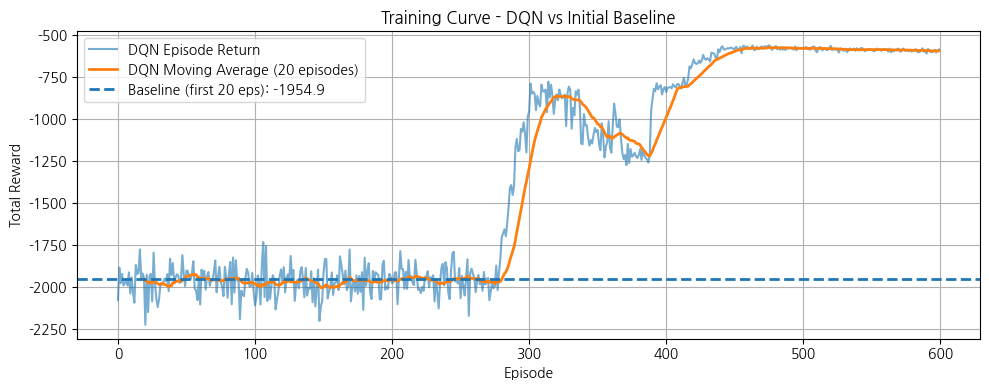

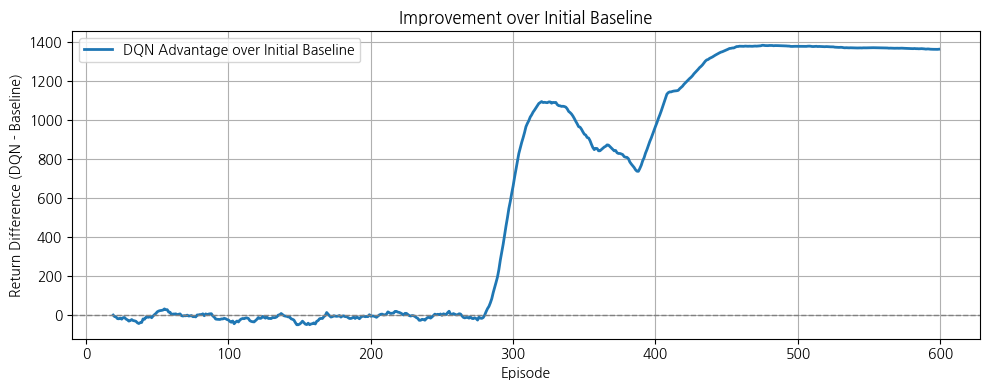

In [ ]:
# ============================================================
# 5. 학습 곡선 시각화 (Training Curve / Loss)
# ------------------------------------------------------------
# 1. 성능 지표 (Performance Metric): 에피소드별 총 보상(Total Reward)
# 2. 비교 분석 (Comparative Analysis):
#    - 초기 무작위 정책(Random Policy) 수준인 'Baseline'과 학습된 에이전트의 성능을 비교
# 3. 추세 파악 (Trend Analysis):
#    - 강화학습의 특성상 보상의 분산(Variance)이 크기 때문에,
#      '이동 평균(Moving Average)'을 통해 전체적인 학습 경향성을 시각화합니다.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# (0) Baseline 설정: 학습 초기 성능 (Initial Performance)
# -----------------------------
# 학습 초반(예: 첫 20 에피소드)은 에이전트가 거의 무작위로 행동하는 구간
baseline_window = min(20, len(scores))
baseline_avg_return = float(np.mean(scores[:baseline_window]))
print(f"[INFO] Baseline (first {baseline_window} episodes) avg return: {baseline_avg_return:.1f}")


# -----------------------------
# (1) Training Curve: DQN vs Baseline
# -----------------------------
plt.figure(figsize=(10, 4))

# DQN 에피소드별 리턴
plt.plot(scores, label='DQN Episode Return', alpha=0.6)

# DQN 이동 평균선
if len(scores) >= ma_window:
    dqn_ma = np.convolve(scores, np.ones(ma_window)/ma_window, mode='valid')
    plt.plot(
        range(ma_window - 1, len(scores)),
        dqn_ma,
        label=f'DQN Moving Average ({ma_window} episodes)',
        linewidth=2
    )

# Baseline(초기 성능) 수평선
plt.axhline(
    y=baseline_avg_return,
    linestyle='--',
    linewidth=2,
    label=f'Baseline (first {baseline_window} eps): {baseline_avg_return:.1f}'
)

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Curve - DQN vs Initial Baseline')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# -----------------------------
# (2) 성능 향상도 분석 (Improvement over Baseline)
# -----------------------------
# DQN Moving Average - Baseline 대비 얼마나 보상을 얻었는지 시각화

plt.figure(figsize=(10, 4))

if len(scores) >= ma_window:
    dqn_ma = np.convolve(scores, np.ones(ma_window)/ma_window, mode='valid')
    x_ma = np.arange(ma_window - 1, len(scores))

    # 개선도 = 현재 성능(이동평균) - 초기 성능(Baseline)
    improvement = dqn_ma - baseline_avg_return

    plt.plot(
        x_ma, improvement,
        linewidth=2,
        label='DQN Advantage over Initial Baseline'
    )
else:
    improvement = np.array(scores) - baseline_avg_return
    x_ma = np.arange(len(scores))
    plt.plot(
        x_ma, improvement,
        linewidth=2,
        label='DQN Advantage over Initial Baseline'
    )

# 기준선(0): 초기 baseline과 동일한 성능
plt.axhline(y=0.0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Episode')
plt.ylabel('Return Difference (DQN - Baseline)')
plt.title('Improvement over Initial Baseline')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


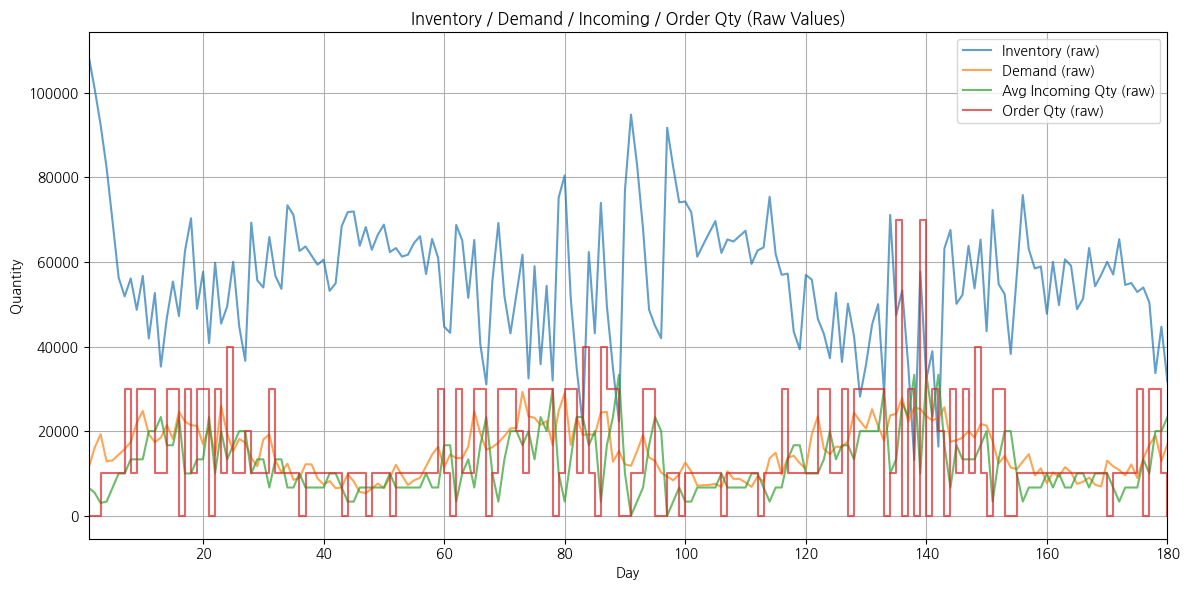

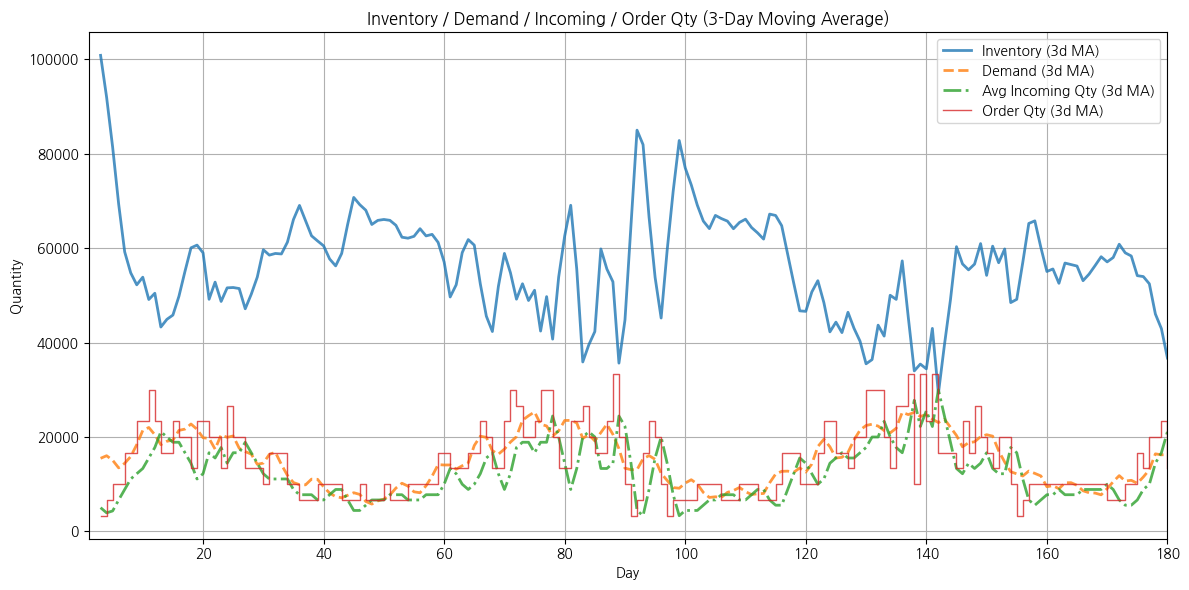

In [ ]:

# ============================================================
# 6. 훈련된 에이전트 행동 분석 (Qualitative Analysis)
# ------------------------------------------------------------
# 1. 재고 추종성 (Inventory Tracking): 수요 변화에 맞춘 재고량 유지
# 2. 안전 재고 (Safety Stock): 불확실한 리드타임과 수요 급증 대비 여유분 확보
# 3. 발주 패턴 (Ordering Pattern): 고정 주문 비용(Fixed Cost)을 고려하여
#    매일 조금씩 주문하는 대신, 필요시 대량으로 주문
# ============================================================

state, _ = env.reset()
done = False

inventories  = []
demands      = []
orders       = []
incoming_avg = []

while not done:
    # 평가 모드: 탐험 없이 greedy 정책 사용
    action = agent.select_action(state, eval_mode=True)
    next_state, _, done, _, info = env.step(action)

    # raw 데이터 기록 (정규화가 아닌 "실제" 값을 보고 싶으면 역변환)
    # state[0]는 정규화된 재고량 → 실제 값으로 변환

    # 1. 재고량 복원
    inv_real = state[0] * env.MAX_CAPACITY
    inventories.append(inv_real)

    # 2. 수요량 및 주문량 기록
    demands.append(info["demand"])
    orders.append(env.action_mapping[action])

    # 3. 입고 예정 물량(Pipeline) 평균 계산 및 복원
    pipeline_norm = state[3:]
    if len(pipeline_norm) > 0:
        incoming_avg.append(pipeline_norm.mean() * env.MAX_CAPACITY)
    else:
        incoming_avg.append(0.0)

    state = next_state

days = np.arange(1, len(inventories) + 1)


# -----------------------------
# [Utility] 이동 평균 함수 (Trend Analysis)
# -----------------------------
def moving_average(arr, window=7):
    arr = np.asarray(arr, dtype=np.float32)
    if len(arr) < window:
        return arr, np.arange(1, len(arr) + 1)
    ma = np.convolve(arr, np.ones(window)/window, mode='valid')
    x  = np.arange(window, len(arr) + 1)
    return ma, x

# 3일 이동 평균 계산
inv_ma, x_inv = moving_average(inventories, window=3)
dem_ma, x_dem = moving_average(demands, window=3)
ord_ma, x_ord = moving_average(orders, window=3)
inc_ma, x_inc = moving_average(incoming_avg, window=3)

# ============================================================
# Plot 1: Raw Values
# ============================================================
plt.figure(figsize=(12, 6))
plt.plot(days, inventories, label='Inventory (raw)', alpha=0.7)
plt.plot(days, demands, label='Demand (raw)', alpha=0.7)
plt.plot(days, incoming_avg, label='Avg Incoming Qty (raw)', alpha=0.7)
plt.step(days, orders, where='post', label='Order Qty (raw)', alpha=0.7)

plt.xlabel('Day')
plt.ylabel('Quantity')
plt.title('Inventory / Demand / Incoming / Order Qty (Raw Values)')
plt.grid(True)
plt.legend(loc='upper right')
plt.xlim(1, len(inventories))
plt.tight_layout()
plt.show()

# ============================================================
# Plot 2: 3-Day Moving Average
# ============================================================
plt.figure(figsize=(12, 6))
plt.plot(x_inv, inv_ma, label='Inventory (3d MA)', linewidth=2, alpha=0.8)
plt.plot(x_dem, dem_ma, label='Demand (3d MA)', linestyle='--', linewidth=2, alpha=0.8)
plt.plot(x_inc, inc_ma, label='Avg Incoming Qty (3d MA)', linestyle='-.', linewidth=2, alpha=0.8)
plt.step(x_ord, ord_ma, where='post', label='Order Qty (3d MA)', linewidth=1, alpha=0.8)

plt.xlabel('Day')
plt.ylabel('Quantity')
plt.title('Inventory / Demand / Incoming / Order Qty (3-Day Moving Average)')
plt.grid(True)
plt.legend(loc='upper right')
plt.xlim(1, len(inventories))
plt.tight_layout()
plt.show()
